In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import kgof.density as density
import kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker 

In [2]:
n = 1000
dim = 1

mean1 = tf.constant([[0.]])
mean2 = tf.constant([[8.]])
noise_mean = tf.constant([[6.]])

2022-04-03 11:29:34.521469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-03 11:29:35.180748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9503 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:da:00.0, compute capability: 7.5


In [3]:
tf.random.set_seed(1)

In [4]:
sample_q = tf.random.normal((n, dim))
sample_p = tf.concat([
    tf.random.normal((n//2, dim)) + mean1,
    tf.random.normal((n//2, dim)) + mean2
], axis=0)

noise = tf.random.normal((n, dim)) + noise_mean
conv_sample_q = sample_q + noise
conv_sample_p = sample_p + noise

In [5]:
res = pd.DataFrame({
    "x": tf.concat([sample_q, conv_sample_q, sample_p, conv_sample_p], axis=0).numpy()[:, 0],
    "type": np.repeat(["q", "conv q", "p", "conv p"], n) 
})

<AxesSubplot:xlabel='x', ylabel='Count'>

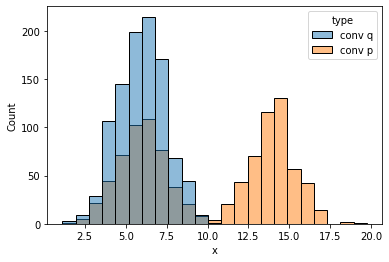

In [6]:
sns.histplot(data=res.loc[res.type.isin(["conv q", "conv p"])], x="x", hue="type")

# All modes

In [212]:
tf.random.set_seed(0)

In [213]:
dim = 2

# k = 2
# delta = 8.
# ratio_sample = 0.3
# ratio_target = 0.5

# target, log_prob_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

## RBM
# dh = 2
# c_off = tf.concat([tf.ones(2) * 1., tf.zeros(dh-2)], axis=0)
# target, log_prob_fn = models.create_rbm(c=0., dx=dim, dh=dh, burnin_number=2000, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_rbm(c=c_off, dx=dim, dh=dh, burnin_number=2000, return_logprob=True)


## t-banana
nmodes = 10
nbanana = 5
ratio_s_var = 1.

ratio_target = [1/nmodes] * nmodes

random_weights = tf.exp(tf.random.normal((nmodes,)) * ratio_s_var)
ratio_sample = random_weights / tf.reduce_sum(random_weights)
print("ratio sample:", ratio_sample.numpy())

loc = tfp.distributions.Uniform(low=-tf.ones((dim,))*50, high=tf.ones((dim,))*50).sample(nmodes) # uniform in [-20, 20]^d
print("means", loc)

b = 0.003 # 0.03
target, log_prob_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_target, loc=loc, b=b,
    nbanana=nbanana, return_logprob=True)
proposal_off, log_prob_off_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_sample, loc=loc, b=b,
    nbanana=nbanana, return_logprob=True)


## scaled Gaussian 
# ratio_t = 0.5
# ratio_s = 0.3
# target, log_prob_fn = models.create_mixture_gaussian_scaled(ratio=ratio_t, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_scaled(ratio=ratio_s, return_logprob=True)

ratio sample: [0.26847887 0.09043504 0.03893972 0.02102416 0.01719953 0.09482022
 0.05842447 0.19452642 0.10822832 0.1079233 ]
means tf.Tensor(
[[ 30.850624    21.793678    -2.8520584   -2.2961273  -47.464836
  -37.048294    23.749985   -16.390038   -20.778418     8.855511  ]
 [-33.257523    36.754395    10.536575    23.39692    -37.837555
    1.9452591   18.663872    28.164268   -13.216137    -6.1206207 ]
 [ -4.0771484  -33.40682     -3.681408     8.160164     2.4738426
   49.923935    -6.6683884  -48.540306   -26.45271    -19.12632   ]
 [ 15.233673    32.454147     3.040409   -44.062378    46.3275
  -13.349567    35.74356     -1.6536827   35.894333   -35.04809   ]
 [-26.225864   -10.352993    42.282043   -21.997118    40.168343
  -22.477806   -27.264477     1.1324654   49.665962    26.9096    ]
 [ -5.1683197  -20.337093   -19.150888     4.9318314  -17.107628
   41.55744     -0.20542145  15.611099    -3.103794    45.249786  ]
 [  9.788586    15.399231   -22.528421   -15.656185   -19.3

In [214]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

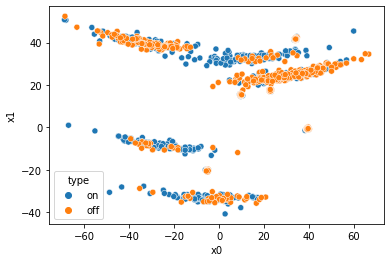

In [215]:
_ = sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")

In [216]:
ntrain = n // 2
threshold = 1.

samples_init = samples_off
# samples_init = samples_on

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

start_pts = sample_off_train
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)

In [217]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [218]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [219]:
std = 0.9

In [220]:
T = 500

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=sample_off_train, ind_pair_list=ind_pair_list, **proposal_dict)

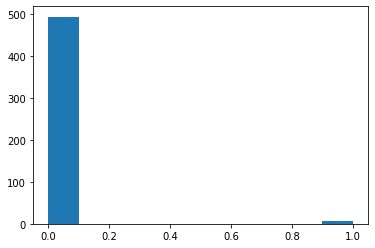

In [221]:
xx = (np.sum(mh.if_accept.numpy(), axis=0) > 0.).astype(np.float32)
_ = plt.hist(xx)

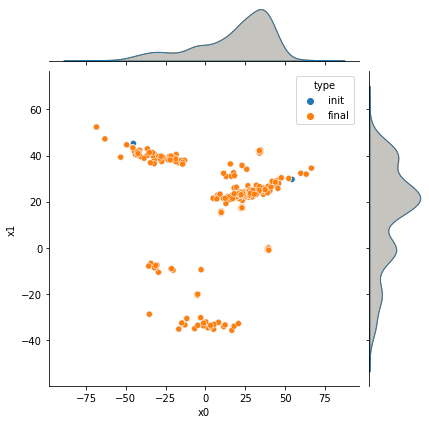

In [222]:
x_0 = mh.x[0, :, :].numpy()
x_t = mh.x[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "init"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "final"

perturbed_df = pd.concat([x0_df, xt_df], ignore_index=True)

_ = sns.jointplot(data=perturbed_df, x="x0", y="x1", hue="type")

In [223]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [123]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

In [225]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.03245942571785269 
after: 0.03245942571785269


In [ ]:
def repeat_experiment(nrep, B_scale):    
    num_boot = 800
    alpha = 0.05

    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=off_target2, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    multinom_one_sample = multinom_samples[0, :]
    
    p_val_list = []
    for i in trange(nrep):
        off_sample = off_target.sample(n)
    
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(target=off_target, kernel=kernel)
        bootstrap = Bootstrap(ksd, n)
        
        multinom_one_sample = multinom_samples[i, :]
        
        _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=off_sample, multinom_samples=multinom_one_sample)

        p_val_list.append(p_val)
        
    res = pd.DataFrame(p_val_list, columns=["pval"])
    return res

In [ ]:
def repeat_experiment_rbm(nrep, B_scale):    
    off_target2, log_prob_off_fn2 = models.create_rbm(
        B_scale=B_scale, c=c_loc_off, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)

    num_boot = 800
    alpha = 0.05

    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=off_target2, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    multinom_one_sample = multinom_samples[0, :]
    
    p_val_list = []
    for i in trange(nrep):
        off_sample2 = off_target2.sample(n)
        syn_sample = off_sample2 #!
    
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(target=off_target2, kernel=kernel)
        bootstrap = Bootstrap(ksd, n)
        
        multinom_one_sample = multinom_samples[i, :]
        
        _, p_val2 = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=off_sample2, multinom_samples=multinom_one_sample)
        _, p_val_sync = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=syn_sample, multinom_samples=multinom_one_sample)

        p_val_list.append((p_val2, "builtin"))
        p_val_list.append((p_val_sync, "synthetic"))
        
    res = pd.DataFrame(p_val_list, columns=["pval", "type"])
    return res